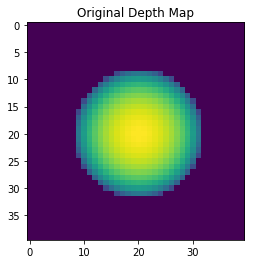

Noise in E(x, y): 0.0


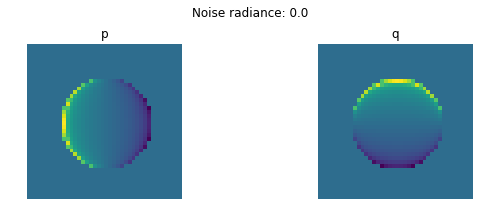

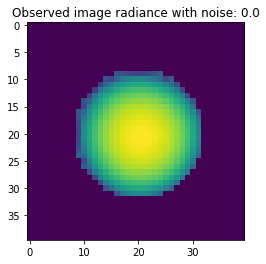

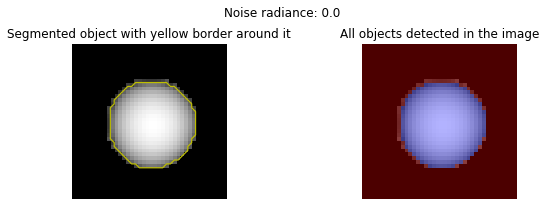

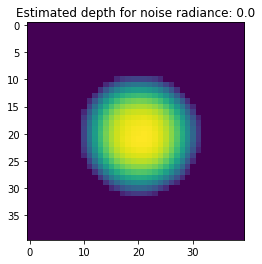

Noise in E(x, y): 0.05


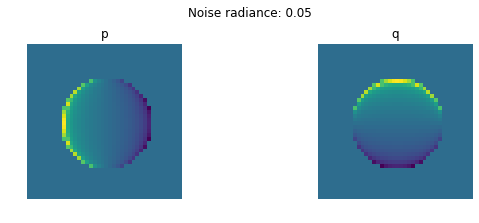

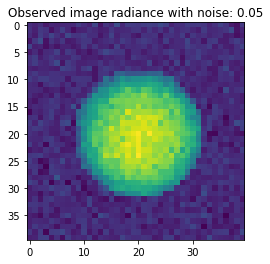

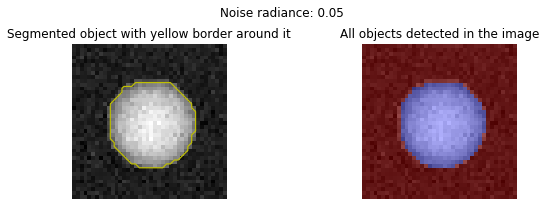

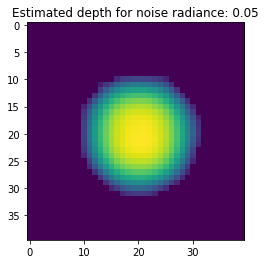

Noise in E(x, y): 0.1


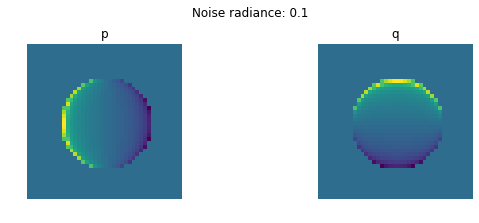

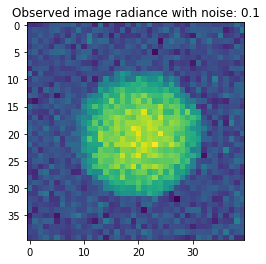

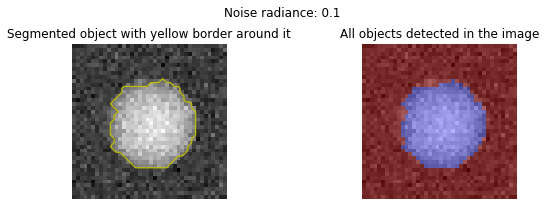

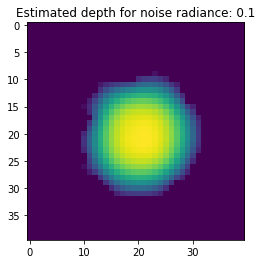

Noise in E(x, y): 0.15


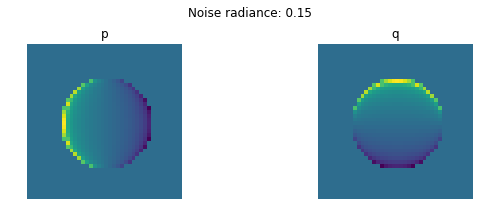

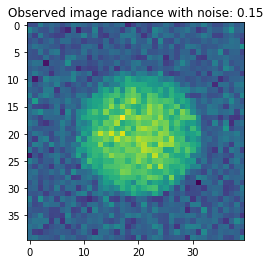

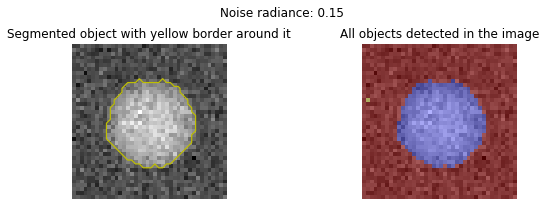

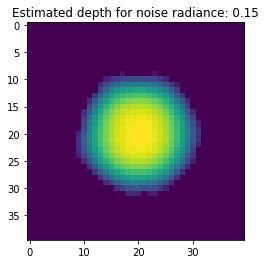

In [27]:
# Import packages
import create_sphere_depth_map as csdm
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage import morphology
from skimage.color import label2rgb
from scipy import ndimage as ndi

radiance_noise_values = [0.0, 0.05, 0.1, 0.15]
image_size = 40
Z_original = csdm.create_depth_map_of_sphere(image_size)
object_map = np.zeros((image_size, image_size))
object_map[Z_original > 0] = 1

fig1 = plt.imshow(Z_original)
plt.title('Original Depth Map')
plt.show()

for iteration in range(len(radiance_noise_values)):
    print("Noise in E(x, y): " + str(radiance_noise_values[iteration]))
    # First we construct the depthmap of the sphere.
    source_vector = [0, 0, 1]
    source_noise = 0
    radiance_noise = radiance_noise_values[iteration]
    image_radius = 0.3*image_size
    num_iter = 1100
    lambda_value = 150
    depth_num_iter = 900

    # Define the source vector and add noise to it.
    source_vector = source_vector + np.random.normal(0, 1, 3)*source_noise
    source_magnitude = np.linalg.norm(source_vector)

    gradient_pq = np.zeros(shape=(image_size, image_size, 3))

    # Calculate the gradient and the therefore the lambertian surface radiance equation
    # to calculate the radiance at each point.
    E = np.zeros((image_size, image_size))
    for i in range(0, image_size - 1):
        for j in range(0, image_size - 1):
             if object_map[i][j]:
                p = Z_original[i][j] - Z_original[i][j-1]
                q = Z_original[i][j] - Z_original[i-1][j]
                gradient_pq[i][j] = np.array([p, q, 1])
                gradient_magnitude = np.linalg.norm(gradient_pq[i][j])
                # Threshold with zero.
                E[i][j] = max(np.dot(gradient_pq[i][j], source_vector)/(source_magnitude*gradient_magnitude), 0)

    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True, constrained_layout=True)
    axes[0].imshow(gradient_pq[:,:,0])
    axes[0].set_title('p')
    axes[1].imshow(gradient_pq[:,:,1])
    axes[1].set_title('q')
    for a in axes:
        a.axis('off')
    fig.suptitle('Noise radiance: ' + str(radiance_noise))
    plt.show()

    # Calculate the noise added to the radiance.
    noise_vector = np.random.normal(0, 1, image_size * image_size)*radiance_noise
    noise_matrix = noise_vector.reshape(image_size, image_size)
    E = E + noise_matrix

    fig = plt.imshow(E)
    plt.title('Observed image radiance with noise: ' + str(radiance_noise))
    plt.show()

    # First we extract the image. Then we extract the boundary.
    # Second attempted.
    E_normalized = cv.normalize(E, None, 255,0, cv.NORM_MINMAX, cv.CV_8UC1)
    elevation_map = sobel(E_normalized)

    markers = np.zeros_like(E_normalized)
    markers[E_normalized < 80] = 1
    markers[E_normalized > 140] = 2

    segmentation = morphology.watershed(elevation_map, markers)
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    labeled_objects, num_objects = ndi.label(segmentation)
    image_label_overlay = label2rgb(labeled_objects, image=E_normalized)

    # Remove undesired objects and retain the biggest segment.
    max_size = 0
    max_label = 1
    for i in range(1, num_objects):
        size_object = labeled_objects[labeled_objects == i].size
        if size_object > max_size:
            max_size = size_object
            max_label = i

    segmentation = (labeled_objects == max_label)

    # First attempted segmentation method.
    # E_normalized = cv.normalize(E, None, 255,0, cv.NORM_MINMAX, cv.CV_8UC1)
    # ret, thresh = cv.threshold(E_normalized, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    # # noise removal
    # kernel = np.ones((3,3), np.uint8)
    # opening = cv.morphologyEx(E_normalized, cv.MORPH_OPEN, kernel, iterations = 2)
    # sure_bg = cv.dilate(opening, kernel, iterations=3)
    # dist_transform = cv.distanceTransform(opening, cv.DIST_L2,5)
    # ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    # sure_fg = np.uint8(sure_fg)
    # unknown = cv.subtract(sure_bg,sure_fg)
    # # Marker labelling
    # ret, markers = cv.connectedComponents(sure_fg)

    # # Add one to all labels so that sure background is not 0, but 1
    # markers = markers+1

    # # Now, mark the region of unknown with zero
    # markers[unknown==255] = 0

    # E_normalized = cv.cvtColor(E_normalized, cv.COLOR_GRAY2BGR)
    # markers = cv.watershed(E_normalized, markers)

    # Display the segmented image.
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True, constrained_layout=True)
    axes[0].imshow(E_normalized, cmap=plt.cm.gray, interpolation='nearest')
    axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
    axes[0].set_title('Segmented object with yellow border around it')
    axes[1].imshow(image_label_overlay, interpolation='nearest')
    axes[1].set_title('All objects detected in the image')
    for a in axes:
        a.axis('off')
    fig.suptitle('Noise radiance: ' + str(radiance_noise))
    plt.show()

    # Shown below is the segmented image along with the boundary.

    # Extract the boundary of an image
    segmentation_bit = np.uint8(segmentation * 255)
    (_, contours, _) = cv.findContours(segmentation_bit, cv.RETR_EXTERNAL, 
        cv.CHAIN_APPROX_NONE)
    boundary_map = np.zeros((image_size, image_size))
    for i in range(0, int(contours[0].size/2)):
        boundary_map[contours[0][i][0][1]][contours[0][i][0][0]] = 1

    # Calculate the boundary at the gradient.
    # p, q is initialized using the gradient at the boundary.
    del_Y, del_X = np.gradient(E)
    gradient_pq_estimated = np.zeros(shape=(image_size, image_size, 3))

    # initialize p,q values at the boundaries.
    del_radience = np.dstack((del_X, del_Y, np.ones((image_size, image_size))));
    boundary_map_3d = np.dstack((boundary_map, boundary_map, np.ones((image_size, image_size))));
    gradient_pq_estimated = np.multiply(del_radience, boundary_map_3d)

    # The next estimates.
    next_gradient_pq = np.dstack((np.zeros(shape=(image_size, image_size, 2)), np.ones((image_size, image_size))))

    # Start the shape from shading iterative solution.
    for k in range(0, num_iter):
        for i in range(1, image_size - 1):
            for j in range(1, image_size - 1):
                # Only update values inside the boundary.
                if segmentation[i][j] and (not boundary_map[i][j]):
                    # Current value of radiance estimated by our model.
                    gradient_magnitude = np.linalg.norm(gradient_pq_estimated[i][j])
                    current_estimated_radiance = np.dot(gradient_pq_estimated[i][j], source_vector)/(source_magnitude*gradient_magnitude)
                    
                    # Compute the gradient of R(p, q) with respect to p and q.
                    denominator_gradient = source_magnitude*math.pow(gradient_magnitude, 3)
                    Rp = (gradient_pq_estimated[i][j][0] + (gradient_pq_estimated[i][j][0]**2)*source_vector[1] - gradient_pq_estimated[i][j][0] - \
                        gradient_pq_estimated[i][j][1]*gradient_pq_estimated[i][j][0]*source_vector[1])/denominator_gradient
                    Rq = (gradient_pq_estimated[i][j][1] + (gradient_pq_estimated[i][j][0]**2)*source_vector[0] - gradient_pq_estimated[i][j][1] - \
                        gradient_pq_estimated[i][j][1]*gradient_pq_estimated[i][j][0]*source_vector[0])/denominator_gradient
                    
                    # Compute the next q and q estimates.
                    next_gradient_pq[i][j] = 0.25*(gradient_pq_estimated[i+1][j] + gradient_pq_estimated[i][j+1] + gradient_pq_estimated[i-1][j] + gradient_pq_estimated[i][j-1])
                    next_gradient_pq[i][j][0] = next_gradient_pq[i][j][0] + lambda_value*(current_estimated_radiance - E[i][j])*Rp
                    next_gradient_pq[i][j][1] = next_gradient_pq[i][j][1] + lambda_value*(current_estimated_radiance - E[i][j])*Rq

        # Update the gradient values
        gradient_pq_estimated = next_gradient_pq

    estimated_p = np.multiply(gradient_pq_estimated[:,:,0], segmentation)
    estimated_q = np.multiply(gradient_pq_estimated[:,:,1], segmentation)

    # %latex
    # Now we need to find a $z$ such that, $\bigtriangledown^2z = p_x + q_y$

    # Now that the gradient has been estimated at each point. Calculate the depth.
    # Calculate gradient of p with respect to x and of q with respect to y.

    gradient_p_x = np.gradient(estimated_p, axis=1)
    gradient_q_y = np.gradient(estimated_q, axis=0)

    Z_estimated = np.zeros((image_size, image_size))
    next_Z = np.zeros((image_size, image_size))

    for k in range(0, depth_num_iter):
        for i in range(1, image_size - 1):
            for j in range(1, image_size - 1):
                if segmentation[i][j]:
                    next_Z[i][j] = 0.25*(Z_estimated[i-1][j] + Z_estimated[i+1][j] + Z_estimated[i][j-1] + Z_estimated[i][j+1]) + abs(gradient_p_x[i][j]) + abs(gradient_q_y[i][j])

        Z_estimated = segmentation*next_Z

    Z_estimated = Z_estimated*segmentation

    # Show the estimated value of depth.
    fig = plt.imshow(Z_estimated)
    plt.title('Estimated depth for noise radiance: ' + str(radiance_noise))
    plt.show()

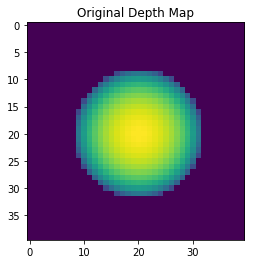

Noise in E(x, y): 0.0


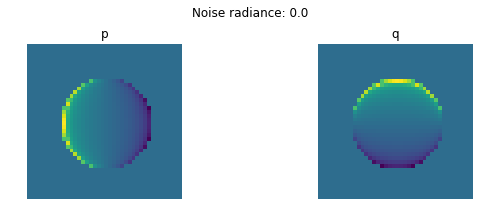

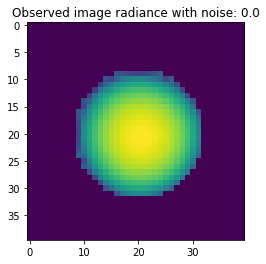

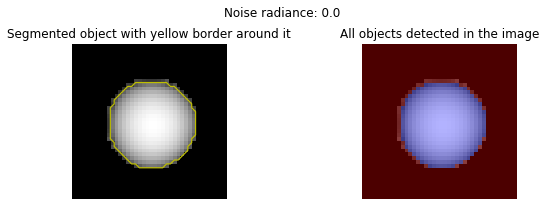

Lambda value: 0.1


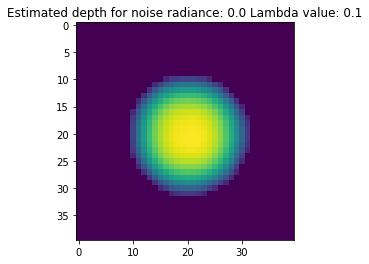

Lambda value: 1


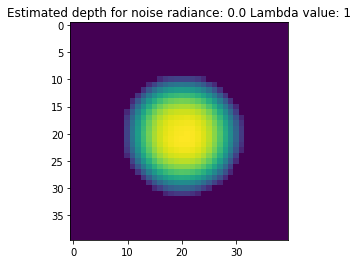

Lambda value: 10


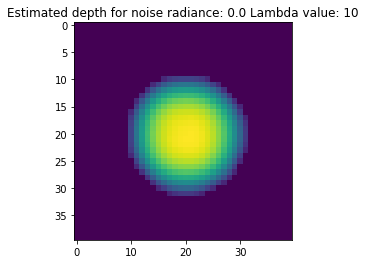

Lambda value: 100


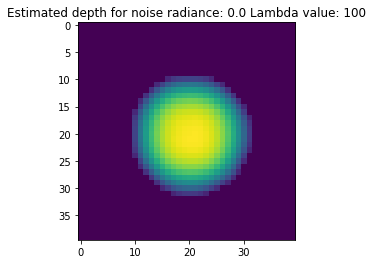

Lambda value: 1000


In [ ]:
# Import packages
import create_sphere_depth_map as csdm
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage import morphology
from skimage.color import label2rgb
from scipy import ndimage as ndi

radiance_noise_values = [0.0]
lambda_values = [0.1, 1, 10, 100, 1000]
image_size = 40
Z_original = csdm.create_depth_map_of_sphere(image_size)
object_map = np.zeros((image_size, image_size))
object_map[Z_original > 0] = 1

fig1 = plt.imshow(Z_original)
plt.title('Original Depth Map')
plt.show()

for iteration in range(len(radiance_noise_values)):
    print("Noise in E(x, y): " + str(radiance_noise_values[iteration]))
    # First we construct the depthmap of the sphere.
    source_vector = [0, 0, 1]
    source_noise = 0
    radiance_noise = radiance_noise_values[iteration]
    image_radius = 0.3*image_size
    num_iter = 1100
    depth_num_iter = 900

    # Define the source vector and add noise to it.
    source_vector = source_vector + np.random.normal(0, 1, 3)*source_noise
    source_magnitude = np.linalg.norm(source_vector)

    gradient_pq = np.zeros(shape=(image_size, image_size, 3))

    # Calculate the gradient and the therefore the lambertian surface radiance equation
    # to calculate the radiance at each point.
    E = np.zeros((image_size, image_size))
    for i in range(0, image_size - 1):
        for j in range(0, image_size - 1):
             if object_map[i][j]:
                p = Z_original[i][j] - Z_original[i][j-1]
                q = Z_original[i][j] - Z_original[i-1][j]
                gradient_pq[i][j] = np.array([p, q, 1])
                gradient_magnitude = np.linalg.norm(gradient_pq[i][j])
                # Threshold with zero.
                E[i][j] = max(np.dot(gradient_pq[i][j], source_vector)/(source_magnitude*gradient_magnitude), 0)

    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True, constrained_layout=True)
    axes[0].imshow(gradient_pq[:,:,0])
    axes[0].set_title('p')
    axes[1].imshow(gradient_pq[:,:,1])
    axes[1].set_title('q')
    for a in axes:
        a.axis('off')
    fig.suptitle('Noise radiance: ' + str(radiance_noise))
    plt.show()

    # Calculate the noise added to the radiance.
    noise_vector = np.random.normal(0, 1, image_size * image_size)*radiance_noise
    noise_matrix = noise_vector.reshape(image_size, image_size)
    E = E + noise_matrix

    fig = plt.imshow(E)
    plt.title('Observed image radiance with noise: ' + str(radiance_noise))
    plt.show()

    # First we extract the image. Then we extract the boundary.
    # Second attempted.
    E_normalized = cv.normalize(E, None, 255,0, cv.NORM_MINMAX, cv.CV_8UC1)
    elevation_map = sobel(E_normalized)

    markers = np.zeros_like(E_normalized)
    markers[E_normalized < 80] = 1
    markers[E_normalized > 140] = 2

    segmentation = morphology.watershed(elevation_map, markers)
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    labeled_objects, num_objects = ndi.label(segmentation)
    image_label_overlay = label2rgb(labeled_objects, image=E_normalized)

    # Remove undesired objects and retain the biggest segment.
    max_size = 0
    max_label = 1
    for i in range(1, num_objects):
        size_object = labeled_objects[labeled_objects == i].size
        if size_object > max_size:
            max_size = size_object
            max_label = i

    segmentation = (labeled_objects == max_label)

    # First attempted segmentation method.
    # E_normalized = cv.normalize(E, None, 255,0, cv.NORM_MINMAX, cv.CV_8UC1)
    # ret, thresh = cv.threshold(E_normalized, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    # # noise removal
    # kernel = np.ones((3,3), np.uint8)
    # opening = cv.morphologyEx(E_normalized, cv.MORPH_OPEN, kernel, iterations = 2)
    # sure_bg = cv.dilate(opening, kernel, iterations=3)
    # dist_transform = cv.distanceTransform(opening, cv.DIST_L2,5)
    # ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    # sure_fg = np.uint8(sure_fg)
    # unknown = cv.subtract(sure_bg,sure_fg)
    # # Marker labelling
    # ret, markers = cv.connectedComponents(sure_fg)

    # # Add one to all labels so that sure background is not 0, but 1
    # markers = markers+1

    # # Now, mark the region of unknown with zero
    # markers[unknown==255] = 0

    # E_normalized = cv.cvtColor(E_normalized, cv.COLOR_GRAY2BGR)
    # markers = cv.watershed(E_normalized, markers)

    # Display the segmented image.
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True, constrained_layout=True)
    axes[0].imshow(E_normalized, cmap=plt.cm.gray, interpolation='nearest')
    axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
    axes[0].set_title('Segmented object with yellow border around it')
    axes[1].imshow(image_label_overlay, interpolation='nearest')
    axes[1].set_title('All objects detected in the image')
    for a in axes:
        a.axis('off')
    fig.suptitle('Noise radiance: ' + str(radiance_noise))
    plt.show()

    # Shown below is the segmented image along with the boundary.

    # Extract the boundary of an image
    segmentation_bit = np.uint8(segmentation * 255)
    (_, contours, _) = cv.findContours(segmentation_bit, cv.RETR_EXTERNAL, 
        cv.CHAIN_APPROX_NONE)
    boundary_map = np.zeros((image_size, image_size))
    for i in range(0, int(contours[0].size/2)):
        boundary_map[contours[0][i][0][1]][contours[0][i][0][0]] = 1

    # Calculate the boundary at the gradient.
    # p, q is initialized using the gradient at the boundary.
    del_Y, del_X = np.gradient(E)
    gradient_pq_estimated = np.zeros(shape=(image_size, image_size, 3))

    # initialize p,q values at the boundaries.
    del_radience = np.dstack((del_X, del_Y, np.ones((image_size, image_size))));
    boundary_map_3d = np.dstack((boundary_map, boundary_map, np.ones((image_size, image_size))));
    gradient_pq_estimated = np.multiply(del_radience, boundary_map_3d)

    # The next estimates.
    next_gradient_pq = np.dstack((np.zeros(shape=(image_size, image_size, 2)), np.ones((image_size, image_size))))

    for lambda_value_iter in range(len(lambda_values)):
        print("Lambda value: " + str(lambda_values[lambda_value_iter]))
        lambda_value = lambda_values[lambda_value_iter]
        # Start the shape from shading iterative solution.
        for k in range(0, num_iter):
            for i in range(1, image_size - 1):
                for j in range(1, image_size - 1):
                    # Only update values inside the boundary.
                    if segmentation[i][j] and (not boundary_map[i][j]):
                        # Current value of radiance estimated by our model.
                        gradient_magnitude = np.linalg.norm(gradient_pq_estimated[i][j])
                        current_estimated_radiance = np.dot(gradient_pq_estimated[i][j], source_vector)/(source_magnitude*gradient_magnitude)
                        
                        # Compute the gradient of R(p, q) with respect to p and q.
                        denominator_gradient = source_magnitude*math.pow(gradient_magnitude, 3)
                        Rp = (gradient_pq_estimated[i][j][0] + (gradient_pq_estimated[i][j][0]**2)*source_vector[1] - gradient_pq_estimated[i][j][0] - \
                            gradient_pq_estimated[i][j][1]*gradient_pq_estimated[i][j][0]*source_vector[1])/denominator_gradient
                        Rq = (gradient_pq_estimated[i][j][1] + (gradient_pq_estimated[i][j][0]**2)*source_vector[0] - gradient_pq_estimated[i][j][1] - \
                            gradient_pq_estimated[i][j][1]*gradient_pq_estimated[i][j][0]*source_vector[0])/denominator_gradient
                        
                        # Compute the next q and q estimates.
                        next_gradient_pq[i][j] = 0.25*(gradient_pq_estimated[i+1][j] + gradient_pq_estimated[i][j+1] + gradient_pq_estimated[i-1][j] + gradient_pq_estimated[i][j-1])
                        next_gradient_pq[i][j][0] = next_gradient_pq[i][j][0] + lambda_value*(current_estimated_radiance - E[i][j])*Rp
                        next_gradient_pq[i][j][1] = next_gradient_pq[i][j][1] + lambda_value*(current_estimated_radiance - E[i][j])*Rq

            # Update the gradient values
            gradient_pq_estimated = next_gradient_pq

        estimated_p = np.multiply(gradient_pq_estimated[:,:,0], segmentation)
        estimated_q = np.multiply(gradient_pq_estimated[:,:,1], segmentation)

        # %latex
        # Now we need to find a $z$ such that, $\bigtriangledown^2z = p_x + q_y$

        # Now that the gradient has been estimated at each point. Calculate the depth.
        # Calculate gradient of p with respect to x and of q with respect to y.

        gradient_p_x = np.gradient(estimated_p, axis=1)
        gradient_q_y = np.gradient(estimated_q, axis=0)

        Z_estimated = np.zeros((image_size, image_size))
        next_Z = np.zeros((image_size, image_size))

        for k in range(0, depth_num_iter):
            for i in range(1, image_size - 1):
                for j in range(1, image_size - 1):
                    if segmentation[i][j]:
                        next_Z[i][j] = 0.25*(Z_estimated[i-1][j] + Z_estimated[i+1][j] + Z_estimated[i][j-1] + Z_estimated[i][j+1]) + abs(gradient_p_x[i][j]) + abs(gradient_q_y[i][j])

            Z_estimated = segmentation*next_Z

        Z_estimated = Z_estimated*segmentation

        # Show the estimated value of depth.
        fig = plt.imshow(Z_estimated)
        plt.title('Estimated depth for noise radiance: ' + str(radiance_noise) + " Lambda value: " + str(lambda_values[lambda_value_iter]))
        plt.show()